In [6]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set_style("whitegrid")
sns.set_style("ticks")
from datetime import datetime
str(datetime.now())

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

import warnings
warnings.filterwarnings('ignore')

import scipy as sp

In [7]:
Runoff_mm = pd.read_excel('../../measurements/glerl/Runoff.xlsx', sheetname='ERI_mm', skiprows=4)
Runoff_mm['Ann'] = pd.to_numeric(Runoff_mm['Ann'], errors='coerce')
Runoff_mm['YEAR'] = pd.to_numeric(Runoff_mm['YEAR'], errors='coerce')

In [8]:
Area = 26858*1e6 #m2
Area_ecl_stClair = 25744*1e6 #m2
conversion_fac_mmy_to_cms = Area_ecl_stClair/1000/365/24/3600
conversion_fac_mmy_to_cms_incl_clair = Area/1000/365/24/3600
conversion_fac_mmy_to_cms_st_clair = (Area - Area_ecl_stClair)/1000/365/24/3600
conversion_fac_mmy_to_cms_eastern = 6.91e+9/1000/365/24/3600
conversion_fac_mmy_to_cms_western = 2.842e+9/1000/365/24/3600
conversion_fac_mmy_to_cms_central = (Area_ecl_stClair - 6.91e+9 - 2.842e+9)/1000/365/24/3600


(0, 155.90237526070038)

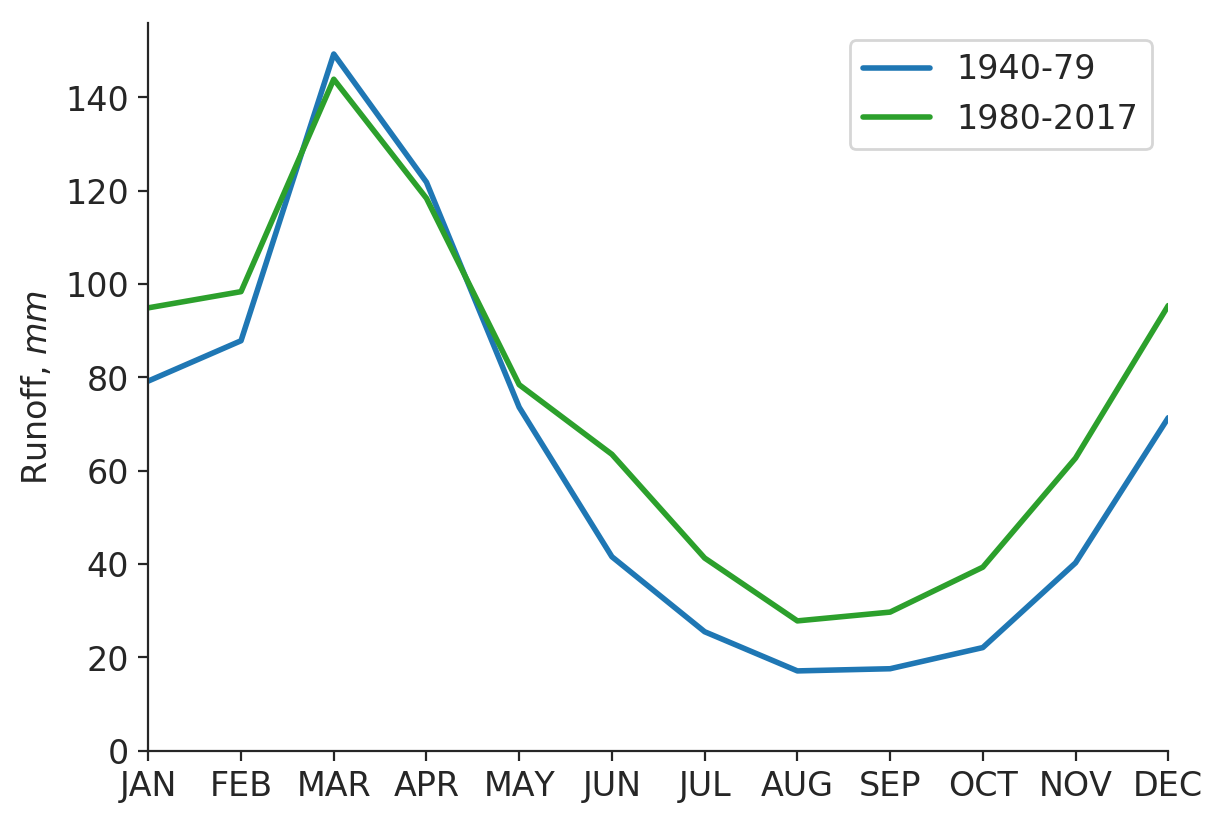

In [11]:
f, axes = plt.subplots(1,1, figsize=(6,4), dpi=200, sharex=True, constrained_layout=True)
axes.plot(Runoff_mm[(Runoff_mm.YEAR>1939) & (Runoff_mm.YEAR<1980)].mean()[1:-1], label='1940-79', lw=2)
axes.plot(Runoff_mm[(Runoff_mm.YEAR>1979) & (Runoff_mm.YEAR<2017)].mean()[1:-1], label='1980-2017', lw=2,  c=sns.color_palette()[2])
axes.set_ylabel('Runoff, $mm$')
# axes.grid(lw=0.3)
sns.despine()
axes.legend()
axes.set_xlim(0,11)
axes.set_ylim(0,None)
# f.savefig('/Users/imarkelo/Google Drive/GDocuments/Lake Erie/Draft/Water Budget/latex_figures/img/runoff_monthly_1940.pdf', dpi=f.dpi)
# f.savefig('/Users/imarkelo/Google Drive/GDocuments/Lake Erie/Draft/Water Budget/latex_draft/img/runoff_monthly_1940.pdf', dpi=f.dpi)



# HYDAT

In [8]:
import pandas as pd
import datetime

In [9]:
WSC_FLOWS = pd.read_pickle('../Loadings Canada 2/data/WSC_FLOWS')

In [54]:
sites = ['02HA019', ]
total_discharge = pd.DataFrame({})
for site in sites:
    discharge = WSC_FLOWS[WSC_FLOWS.index>datetime.datetime(1996,1,1)][site].to_frame()

    discharge = discharge.reset_index()
    discharge = discharge.rename(index=str, columns={site:'Discharge, cms', 'index':'Date'})
    discharge['Source'] = site
#     total_discharge[site] = discharge['Discharge, cms']
    discharge['Flow, CFS'] = discharge['Discharge, cms']/0.028
    total_discharge = pd.concat([total_discharge, discharge])

In [55]:
total_discharge.describe()

,"Discharge, cms","Flow, CFS"
count,585.000000,585.000000
mean,5778.820513,206386.446886
std,619.136725,22112.025901
min,3900.000000,139285.714286
25%,5340.000000,190714.285714
50%,5740.000000,205000.000000
75%,6220.000000,222142.857143
max,8460.000000,302142.857143


In [49]:
df = total_discharge.set_index('Date').groupby(pd.Grouper(freq='Y')).mean().T

In [53]:
df[df.columns[7:]]

Date,2003-12-31 00:00:00,2004-12-31 00:00:00,2005-12-31 00:00:00,2006-12-31 00:00:00,2007-12-31 00:00:00,2008-12-31 00:00:00,2009-12-31 00:00:00,2010-12-31 00:00:00,2011-12-31 00:00:00,2012-12-31 00:00:00,2013-12-31 00:00:00,2014-12-31 00:00:00,2015-12-31 00:00:00,2016-12-31 00:00:00,2017-12-31 00:00:00
"Discharge, cms",199.818904,201.453552,212.892329,175.801918,180.973973,210.703825,194.597904,169.398904,150.555556,204.051913,174.063536,206.831781,225.112329,208.033060,138.790685
"Flow, CFS",7136.389433,7194.769711,7603.297456,6278.639922,6463.356163,7525.136612,6949.925150,6049.960862,5376.984127,7287.568306,6216.554854,7386.849314,8039.726027,7429.752147,4956.810175


# USGS stations:

In [21]:
import hydrofunctions as hf
import pandas as pd
import numpy as np
from zipfile import ZipFile
import os
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import random
sns.set_style("ticks")

In [22]:
river = 'Niagara'

Text(0.5,0,'Year')

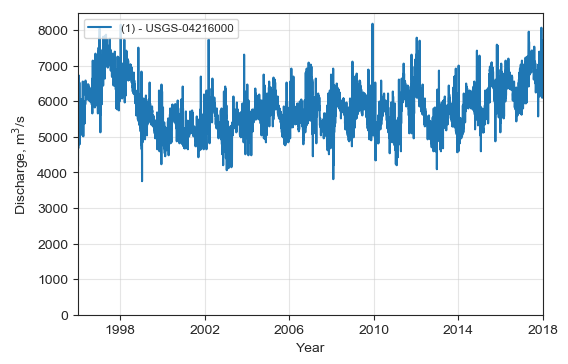

In [23]:
# Finde station here:
# https://www.hydrocloud.org
site = '04216000'
start = '1996-01-01'
end = '2018-11-01'
response = hf.get_nwis(site, 'dv',start, end)
# response.get_data()
discharge = hf.extract_nwis_df(response.json())

discharge.columns

discharge['Flow, CFS']=discharge['USGS:'+site+':00060:00003']

discharge= discharge.reset_index()
discharge['Date']  = discharge['datetime']
discharge['Date'] =pd.to_datetime(discharge['Date'], errors='coerce')
discharge = discharge[['Date', 'Flow, CFS']]
discharge['Source'] = 'USGS-'+site




# discharge = discharge.append(df_Q_heideleberg)

discharge['Discharge, cms'] = 0.028*discharge['Flow, CFS']

site = 'USGS-'+site

river

fig,ax=plt.subplots(1,1,figsize=(6,4), dpi=100)
ax=sns.lineplot(x='Date', y='Discharge, cms', data=discharge, hue='Source',ax=ax)

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes

ax.legend(['(1) - '+site], loc=2, fontsize='small')
ax.set_ylim(0,None)
ax.set_xlim(datetime.datetime(1996,1,1), datetime.datetime(2018,1,1))
ax.grid(alpha=0.5)
ax.set_ylabel("Discharge, m$^3$/s")
ax.set_xlabel("Year")


In [56]:
discharge.describe()

,"Discharge, cms","Flow, CFS"
count,585.000000,585.000000
mean,5778.820513,206386.446886
std,619.136725,22112.025901
min,3900.000000,139285.714286
25%,5340.000000,190714.285714
50%,5740.000000,205000.000000
75%,6220.000000,222142.857143
max,8460.000000,302142.857143


In [35]:
df = discharge.set_index('Date').groupby(pd.Grouper(freq='Y')).mean().T

In [39]:
df[df.columns[7:-1]]

Date,2003-12-31 00:00:00,2004-12-31 00:00:00,2005-12-31 00:00:00,2006-12-31 00:00:00,2007-12-31 00:00:00,2008-12-31 00:00:00,2009-12-31 00:00:00,2010-12-31 00:00:00,2011-12-31 00:00:00,2012-12-31 00:00:00,2013-12-31 00:00:00,2014-12-31 00:00:00,2015-12-31 00:00:00,2016-12-31 00:00:00,2017-12-31 00:00:00
"Flow, CFS",186876.712329,199174.863388,201945.205479,200139.726027,197676.712329,201622.950820,207567.123288,195821.917808,209104.109589,200221.311475,197397.260274,206857.534247,216734.246575,224743.169399,240541.208791
"Discharge, cms",5232.547945,5576.896175,5654.465753,5603.912329,5534.947945,5645.442623,5811.879452,5483.013699,5854.915068,5606.196721,5527.123288,5792.010959,6068.558904,6292.808743,6735.153846


# Station names and locations

In [57]:
import pandas as pd
WSC_STATIONS = pd.read_pickle('../Loadings Canada 2/data/WSC_STATIONS')
WSC_STATIONS = WSC_STATIONS[WSC_STATIONS.Flow == True]

In [62]:
site = '02HA003'

df = WSC_STATIONS[WSC_STATIONS.STATION_NUMBER==site][[
    'STATION_NAME',
    'STATION_NUMBER',
    'LATITUDE',
    'LONGITUDE',
    'DRAINAGE_AREA_GROSS'
]]
df['STATION_NAME'] = df['STATION_NAME'].apply(lambda x: x.title())
df

,STATION_NAME,STATION_NUMBER,LATITUDE,LONGITUDE,DRAINAGE_AREA_GROSS
878,Niagara River At Queenston,02HA003,43.156941,-79.047218,686000.0


In [1]:
from zipfile import ZipFile

import pandas as pd
import pyperclip

stations = pd.read_csv('../../measurements/USGS stream data/OHIO station info.csv')
stations_1 = pd.read_csv(ZipFile('../../measurements/USGS stream data/MICHIGAN stations.zip').open(name='station.csv'))
stations_2 = pd.read_csv(ZipFile('../../measurements/USGS stream data/NEW YORK stations.zip').open(name='station.csv'))




/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (14,27,28,29,32,34) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (5,14,27,28,29,32,34) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (5,8,10,14,18,27,28,29,32,34) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:


stations = stations.append(stations_1.append(stations_2))

station = 'dv04216000'
res = stations[stations.MonitoringLocationIdentifier == 'USGS-'+station[2:]][
    ['MonitoringLocationIdentifier',
        'MonitoringLocationName',
     'LatitudeMeasure',
     'LongitudeMeasure',
     'DrainageAreaMeasure/MeasureValue',
    ]
]
res['MonitoringLocationName'] = res['MonitoringLocationName'].apply(lambda x: x.title())
res = res.values[0]
print('{} {} {} {} {}'.format(*[i for i in res]))
pyperclip.copy('{}\t{}\t{}\t{}\t{}'.format(*[i for i in res]))

USGS-04216000 Niagara River At Buffalo Ny 42.8777778 -78.91638890000002 263700.0
